In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
import seaborn as sns 
from matplotlib import rcParams
from statsmodels.tools.eval_measures import rmse
import warnings
from shutil import copy2

# Matplotlib options
rcParams['figure.figsize'] = (10, 8)
rcParams['axes.grid'] = False
plt.style.use('seaborn-deep')
%matplotlib inline

# Pandas setup
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000) 
pd.set_option('display.max_colwidth', -1) 

warnings.filterwarnings('ignore')

In [2]:
# Read file
path = "./datasets/"
name = "p1"

df = pd.read_csv(path + name + "_clipped.csv", encoding='utf8', parse_dates=True, index_col="DATE")
validation = pd.read_csv(path + name + "_validation.csv", encoding='utf8', parse_dates=True, index_col="DATE")

cols = df.columns
col = cols[5]
# series = df[col]

## Prophet Model
Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In [3]:
prophet_df = df[col].reset_index().rename(columns={"DATE": "ds", col: "y"})
model = Prophet(weekly_seasonality=False, daily_seasonality=False)
model.fit(prophet_df)
future = model.make_future_dataframe(periods=12, freq="M", include_history=True)
predict = model.predict(future)

### Plot Predictions

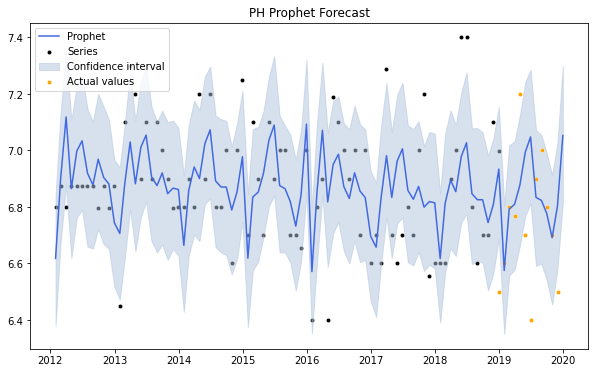

In [4]:
# plot predictions vs actual values
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=df.index, y=col, color="black", label="Series", s=18)
sns.lineplot(data=predict, x="ds", y="yhat", color="royalblue", linestyle="-", label="Prophet")
plt.fill_between(data=predict, x="ds", y1="yhat_lower", y2="yhat_upper", color="lightsteelblue", alpha=0.5, label="Confidence interval")
sns.scatterplot(data=validation, x=validation.index, y=validation[col], color="orange", label="Actual values", s=18)
plt.xlabel("")
plt.ylabel("")
plt.title(f"{col} Prophet Forecast")
plt.legend(loc="upper left");

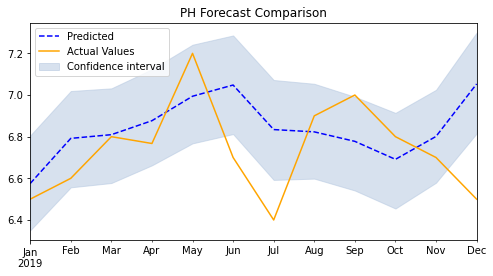

In [5]:
predicted = predict.iloc[len(df):, :]
predicted.index = validation.index
plt.figure(figsize=(8, 4))
predicted.yhat.plot(color="blue", linestyle="--", label="Predicted")
plt.fill_between(data=predicted, x=predicted.index, y1="yhat_lower", y2="yhat_upper", color="lightsteelblue", alpha=0.5, label="Confidence interval")
validation[col].plot(color="orange", linestyle="-", label="Actual Values")
plt.legend(loc="upper left")
plt.xlabel("")
plt.title(f"{col} Forecast Comparison");

In [6]:
print(f"{col} RMSE: {rmse(validation[col], predicted.yhat).round(3)}")

PH RMSE: 0.257


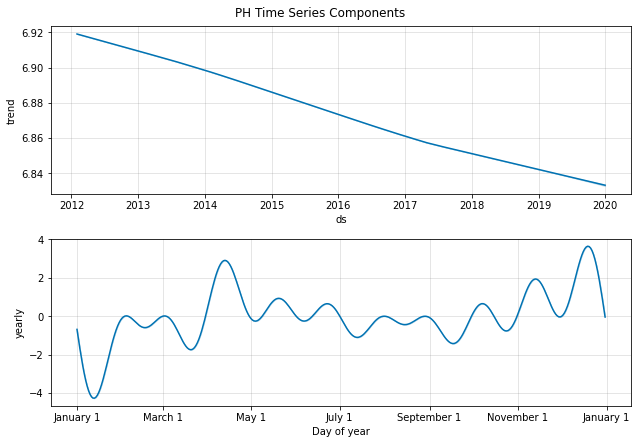

In [7]:
model.plot_components(predict);
plt.suptitle(f"{col} Time Series Components", y=1.02);

In [8]:
# alternative use plotly interactive model
plot_plotly(model, predict)

In [9]:
prophet = predicted.yhat
prophet.name = col
%store prophet

Stored 'prophet' (Series)


In [10]:
copy2("prophet.ipynb", f"./models/prophet/{name}_{col}.ipynb")

'./models/prophet/p1_PH.ipynb'

In [11]:
prophet_reset = prophet.reset_index()
prophet_reset.to_csv(f"./models/forecasts/{name}_{col}_prophet.csv", sep=",", encoding="utf8", index=False)